In [97]:
require('tidyverse')
require('data.table')
PHE.DIR <- "../../../phefiles"
ANTHRO.DIR <- "../../../phefiles/anthro"
BIOMARKER_F_PATH <- "../../../phefiles/biomarker_f"
BIOMARKER_M_PATH <- "../../../phefiles/biomarker_m"

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




# ANTHROPOMETRIC TRAITS 
### remove missing data and outside 6sd

In [69]:
zerosex <- read.table(sprintf("%s/zerosex.keep", PHE.DIR))
onesex <- read.table(sprintf("%s/onesex.keep", PHE.DIR))

In [98]:
COVARIATE_MATRIX <- '/oak/stanford/groups/mrivas/ukbb24983/sqc/ukb24983_GWAS_covar.phe'
# read in covariate matrix
cov_mat <- fread(COVARIATE_MATRIX, data.table=FALSE) %>% select(IID, sex)

In [37]:
# --- WHR --- #
wc <- read.table(sprintf("%s/INI48.phe", ANTRHO.DIR))
hc <- read.table(sprintf("%s/INI49.phe", ANTHRO.DIR))
colnames(wc) <- c("FID", "IID", "wc")
colnames(hc) <- c("FID", "IID", "hc")

In [100]:
table(cov_mat$sex)


     0      1 
264861 223509 

In [103]:
phe <- hc


[1] "Removed 15339 indiviuals who were missing info."


FID,IID,trait,sex,mu_s,s_s,low_c,up_c
<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
4646215,4646215,101.0,1,103.3971,7.605907,57.76164,149.0325
5007659,5007659,108.0,1,103.3971,7.605907,57.76164,149.0325
1038854,1038854,99.5,0,103.3254,10.363672,41.14338,165.5074
5441319,5441319,104.0,1,103.3971,7.605907,57.76164,149.0325
5743544,5743544,93.5,0,103.3254,10.363672,41.14338,165.5074
3266897,3266897,113.0,1,103.3971,7.605907,57.76164,149.0325


[1] "Removed 199 indiviuals who were outside 6sd."


In [123]:

# TODO - should this processing be done separately for M + F??
processAnthroTrait <- function(phe){
    phe1 <- inner_join(phe, cov_mat, by=c("IID"))
    trait_name <- colnames(phe)[3]
    colnames(phe1)[3] <- "trait"
    phe2 <- phe1 %>% filter(trait>0)
    print(sprintf("Removed %s indiviuals who were missing info.", nrow(phe)-nrow(phe2)))
    phe2.1 <- phe2 %>% 
        group_by(sex) %>% 
        mutate(mu_s=mean(trait), s_s=sd(trait)) %>% 
        mutate(low_c=mu_s-(6*s_s),up_c=mu_s+(6*s_s))
    phe3 <- phe2.1 %>% ungroup() %>% 
        filter(trait > low_c & trait < up_c) %>% 
        select(FID, IID, trait)
    colnames(phe3)[3] <- trait_name
    print(sprintf("Removed %s indiviuals who were outside 6sd.", nrow(phe2)-nrow(phe3)))

    return(phe3)
}


In [124]:
hc_f <- processAnthroTrait(hc) %>% as_tibble()
wc_f <- processAnthroTrait(wc) %>% as_tibble()


[1] "Removed 15339 indiviuals who were missing info."
[1] "Removed 199 indiviuals who were outside 6sd."
[1] "Removed 15281 indiviuals who were missing info."
[1] "Removed 21 indiviuals who were outside 6sd."


In [121]:
whr_tab <- inner_join(wc_f, hc_f %>% select(-FID), by=c("IID")) %>% mutate(whr=wc/hc)
head(whr_tab)

FID,IID,wc,hc,whr
<int>,<int>,<dbl>,<dbl>,<dbl>
4646215,4646215,98.0,101.0,0.9702970
5007659,5007659,100.0,108.0,0.9259259
1038854,1038854,75.5,99.5,0.7587940
5441319,5441319,106.0,104.0,1.0192308
5743544,5743544,87.5,93.5,0.9358289
3266897,3266897,118.0,113.0,1.0442478


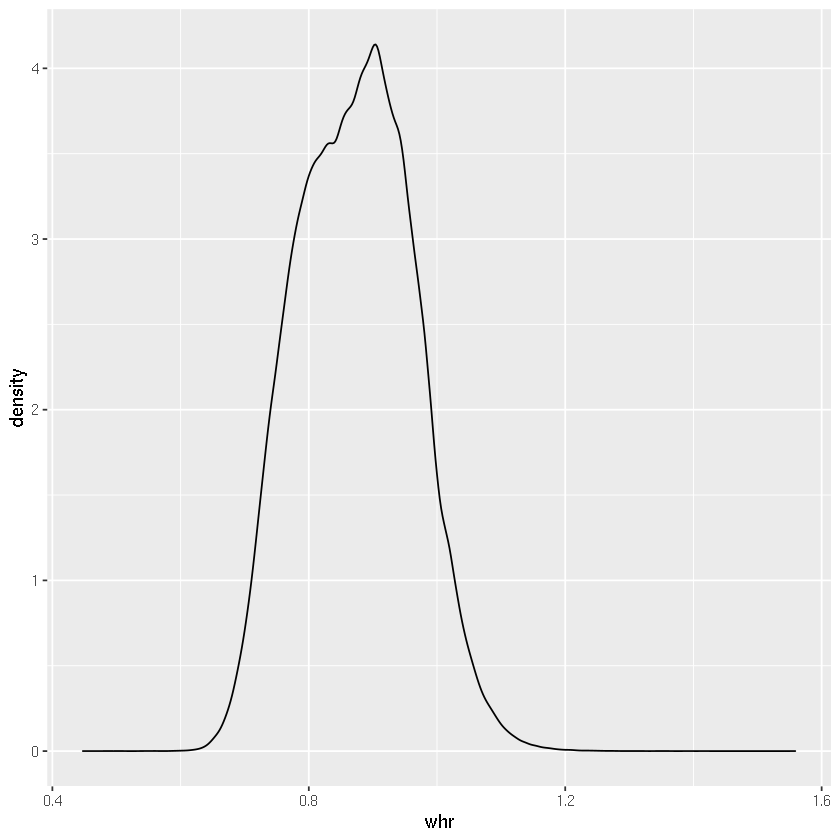

In [107]:
ggplot(whr_tab, aes(x=whr))+geom_density()

In [108]:
# write it out
write_tsv(whr_tab %>% select(-wc, -hc), sprintf("%s/whr.phe", ANTHRO.DIR))

In [111]:
# --- fat ratios --- #
total <- read.table(sprintf("%s/INI23100.phe", ANTHRO.DIR))
leg_l <- read.table(sprintf("%s/INI23116.phe", ANTHRO.DIR))
leg_r <- read.table(sprintf("%s/INI23112.phe", ANTHRO.DIR))
arm_l <- read.table(sprintf("%s/INI23124.phe", ANTHRO.DIR))
arm_r <- read.table(sprintf("%s/INI23120.phe", ANTHRO.DIR))
trunk <- read.table(sprintf("%s/INI23128.phe", ANTHRO.DIR))

colnames(leg_l) <- c("FID", "IID", "leg_l")
colnames(leg_r) <- c("FID", "IID", "leg_r")
colnames(arm_l) <- c("FID", "IID", "arm_l")
colnames(arm_r) <- c("FID", "IID", "arm_r")
colnames(trunk) <- c("FID", "IID", "trunk")
colnames(total) <- c("FID", "IID", "total")

In [112]:
# filter 
leg_l_f <- processAnthroTrait(leg_l) %>% as_tibble()
leg_r_f <- processAnthroTrait(leg_r) %>% as_tibble()
arm_l_f <- processAnthroTrait(arm_l) %>% as_tibble()
arm_r_f <- processAnthroTrait(arm_r) %>% as_tibble()
trunk_f <- processAnthroTrait(trunk) %>% as_tibble()
total_f <- processAnthroTrait(total) %>% as_tibble()

[1] "Removed 22804 indiviuals who were missing info."
[1] "Removed 461 indiviuals who were outside 6sd."
[1] "Removed 22776 indiviuals who were missing info."
[1] "Removed 494 indiviuals who were outside 6sd."
[1] "Removed 22946 indiviuals who were missing info."
[1] "Removed 765 indiviuals who were outside 6sd."
[1] "Removed 22872 indiviuals who were missing info."
[1] "Removed 737 indiviuals who were outside 6sd."
[1] "Removed 23043 indiviuals who were missing info."
[1] "Removed 48 indiviuals who were outside 6sd."
[1] "Removed 23522 indiviuals who were missing info."
[1] "Removed 156 indiviuals who were outside 6sd."


In [115]:
# calculate
legs <- inner_join(leg_l_f, leg_r_f %>% select(-FID), by="IID") %>% mutate(legs=leg_l+leg_r)
arms <- inner_join(arm_l_f, arm_r_f %>% select(-FID), by="IID") %>% mutate(arms=arm_l+arm_r)
legs2 <- inner_join(total_f, legs %>% select(-FID), by="IID") %>% mutate(lfr=legs/total)
arms2 <- inner_join(total_f, arms %>% select(-FID), by="IID") %>% mutate(afr=arms/total)
trunk2 <- inner_join(total_f, trunk_f %>% select(-FID), by="IID") %>% mutate(tfr=trunk/total)

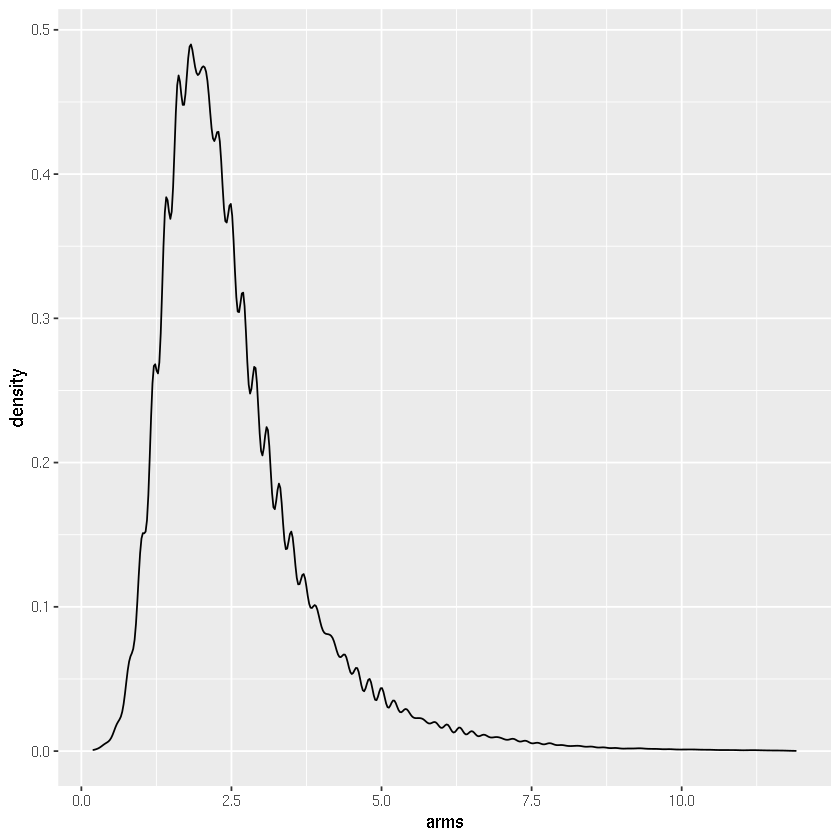

In [119]:
ggplot(arms2, aes(x=arms))+geom_density()

In [120]:
# write it out
legs2 %>% select(FID, IID, lfr) %>% write_tsv(sprintf("%s/lfr.phe", ANTHRO.DIR))
arms2 %>% select(FID, IID, afr) %>% write_tsv(sprintf("%s/afr.phe", ANTHRO.DIR))
trunk2 %>% select(FID, IID, tfr) %>% write_tsv(sprintf("%s/tfr.phe", ANTHRO.DIR))

# BIOMARKER TRAITS
### remove NAs

In [12]:
biomarker_files <- list.files(path=BIOMARKER_F_PATH, pattern="*.phe")

In [89]:
traits <- unique(sapply(biomarker_files, function(x) strsplit(x, "\\.")[[1]][[1]]))

traits.to.rem <- c("Fasting_glucose", "Oestradiol", "Rheumatoid_factor", "Microalbumin_in_urine")

In [92]:
list.traits <- data.frame(setdiff(traits, traits.to.rem), stringsAsFactors=FALSE)
colnames(list.traits) <- ""
write_tsv(list.traits, sprintf("%s/list_traits.txt", PHE.DIR))

In [74]:
 remNaBio <- function(trait) {
    print(trait)
    df <- read_tsv(sprintf("%s/%s.phe", BIOMARKER_F_PATH, trait))
    df2 <- df[!is.na(df[,3]),] 
    df2 %>% write_tsv(sprintf("%s_v2/%s.phe", BIOMARKER_F_PATH, trait))
    print(nrow(df2)-nrow(df))

    rm(df)
    rm(df2)
    df <- read_tsv(sprintf("%s/%s.phe", BIOMARKER_M_PATH, trait))
    df2 <- df[!is.na(df[,3]),] 
    df2 %>% write_tsv(sprintf("%s_v2/%s.phe", BIOMARKER_M_PATH, trait))
        print(nrow(df2)-nrow(df))
}

In [77]:
lapply(list.traits[,1], remNaBio)

[1] "Alanine_aminotransferase.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Alanine_aminotransferase = col_double()
)



[1] -106


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Alanine_aminotransferase = col_double()
)



[1] -209
[1] "Albumin.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Albumin = col_double()
)



[1] -20200


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Albumin = col_double()
)



[1] -14402
[1] "Alkaline_phosphatase.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Alkaline_phosphatase = col_double()
)



[1] -81


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Alkaline_phosphatase = col_double()
)



[1] -80
[1] "Apolipoprotein_A.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Apolipoprotein_A = col_double()
)



[1] -22099


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Apolipoprotein_A = col_double()
)



[1] -14762
[1] "Apolipoprotein_B.adjust.statins.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Apolipoprotein_B_adjstatins = col_double()
)



[1] -824


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Apolipoprotein_B_adjstatins = col_double()
)



[1] -1295
[1] "Apolipoprotein_B.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Apolipoprotein_B = col_double()
)



[1] -824


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Apolipoprotein_B = col_double()
)



[1] -1295
[1] "Aspartate_aminotransferase.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Aspartate_aminotransferase = col_double()
)



[1] -855


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Aspartate_aminotransferase = col_double()
)



[1] -802
[1] "C_reactive_protein.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  C_reactive_protein = col_double()
)



[1] -471


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  C_reactive_protein = col_double()
)



[1] -544
[1] "Calcium.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Calcium = col_double()
)



[1] -20283


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Calcium = col_double()
)



[1] -14459
[1] "Cholesterol.adjust.statins.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Cholesterol_adjstatins = col_double()
)



[1] -125


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Cholesterol_adjstatins = col_double()
)



[1] -75
[1] "Cholesterol.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Cholesterol = col_double()
)



[1] -125


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Cholesterol = col_double()
)



[1] -75
[1] "Creatinine_in_urine.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Creatinine_in_urine = col_double()
)



[1] -6514


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Creatinine_in_urine = col_double()
)



[1] -4489
[1] "Creatinine.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Creatinine = col_double()
)



[1] -183


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Creatinine = col_double()
)



[1] -165
[1] "Cystatin_C.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Cystatin_C = col_double()
)



[1] -185


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Cystatin_C = col_double()
)



[1] -147
[1] "Direct_bilirubin.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Direct_bilirubin = col_double()
)



[1] -48169


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Direct_bilirubin = col_double()
)



[1] -12697
[1] "eGFR.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  eGFR = col_double()
)



[1] -183


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  eGFR = col_double()
)



[1] -165
[1] "Fasting_glucose.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Fasting_glucose = col_double()
)



[1] -213619


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Fasting_glucose = col_double()
)



[1] -178709
[1] "Gamma_glutamyltransferase.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Gamma_glutamyltransferase = col_double()
)



[1] -194


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Gamma_glutamyltransferase = col_double()
)



[1] -190
[1] "Glucose.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Glucose = col_double()
)



[1] -20458


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Glucose = col_double()
)



[1] -14624
[1] "Glycated_haemoglobin_HbA1c.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Glycated_haemoglobin_HbA1c = col_double()
)



[1] -9857


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Glycated_haemoglobin_HbA1c = col_double()
)



[1] -8400
[1] "HDL_cholesterol.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  HDL_cholesterol = col_double()
)



[1] -20286


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  HDL_cholesterol = col_double()
)



[1] -14482
[1] "IGF_1.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  IGF_1 = col_double()
)



[1] -1387


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  IGF_1 = col_double()
)



[1] -1131
[1] "LDL_direct.adjust.statins.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  LDL_direct_adjstatins = col_double()
)



[1] -472


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  LDL_direct_adjstatins = col_double()
)



[1] -452
[1] "LDL_direct.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  LDL_direct = col_double()
)



[1] -472


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  LDL_direct = col_double()
)



[1] -452
[1] "Lipoprotein_A.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Lipoprotein_A = col_double()
)



[1] -44269


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Lipoprotein_A = col_double()
)



[1] -38857
[1] "Microalbumin_in_urine.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Microalbumin_in_urine = col_double()
)



[1] -160935


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Microalbumin_in_urine = col_double()
)



[1] -123122
[1] "Non_albumin_protein.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Non_albumin_protein = col_double()
)



[1] -20469


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Non_albumin_protein = col_double()
)



[1] -14690
[1] "Oestradiol.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Oestradiol = col_double()
)



[1] -171636


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Oestradiol = col_double()
)



[1] -170895
[1] "Phosphate.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Phosphate = col_double()
)



[1] -20575


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Phosphate = col_double()
)



[1] -14737
[1] "Potassium_in_urine.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Potassium_in_urine = col_double()
)



[1] -6982


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Potassium_in_urine = col_double()
)



[1] -4904
[1] "Rheumatoid_factor.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Rheumatoid_factor = col_double()
)



[1] -199677


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Rheumatoid_factor = col_double()
)



[1] -170673
[1] "SHBG.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  SHBG = col_double()
)



[1] -22523


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  SHBG = col_double()
)



[1] -15811
[1] "Sodium_in_urine.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Sodium_in_urine = col_double()
)



[1] -7161


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Sodium_in_urine = col_double()
)



[1] -4669
[1] "Testosterone.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Testosterone = col_double()
)



[1] -36687


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Testosterone = col_double()
)



[1] -1958
[1] "Total_bilirubin.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Total_bilirubin = col_double()
)



[1] -1002


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Total_bilirubin = col_double()
)



[1] -865
[1] "Total_protein.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Total_protein = col_double()
)



[1] -20387


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Total_protein = col_double()
)



[1] -14621
[1] "Triglycerides.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Triglycerides = col_double()
)



[1] -229


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Triglycerides = col_double()
)



[1] -271
[1] "Urate.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Urate = col_double()
)



[1] -378


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Urate = col_double()
)



[1] -299
[1] "Urea.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Urea = col_double()
)



[1] -250


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Urea = col_double()
)



[1] -209
[1] "Vitamin_D.phe"


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Vitamin_D = col_double()
)



[1] -12613


Parsed with column specification:
cols(
  FID = col_double(),
  IID = col_double(),
  Vitamin_D = col_double()
)



[1] -5558


[[1]]
[1] -209

[[2]]
[1] -14402

[[3]]
[1] -80

[[4]]
[1] -14762

[[5]]
[1] -1295

[[6]]
[1] -1295

[[7]]
[1] -802

[[8]]
[1] -544

[[9]]
[1] -14459

[[10]]
[1] -75

[[11]]
[1] -75

[[12]]
[1] -4489

[[13]]
[1] -165

[[14]]
[1] -147

[[15]]
[1] -12697

[[16]]
[1] -165

[[17]]
[1] -178709

[[18]]
[1] -190

[[19]]
[1] -14624

[[20]]
[1] -8400

[[21]]
[1] -14482

[[22]]
[1] -1131

[[23]]
[1] -452

[[24]]
[1] -452

[[25]]
[1] -38857

[[26]]
[1] -123122

[[27]]
[1] -14690

[[28]]
[1] -170895

[[29]]
[1] -14737

[[30]]
[1] -4904

[[31]]
[1] -170673

[[32]]
[1] -15811

[[33]]
[1] -4669

[[34]]
[1] -1958

[[35]]
[1] -865

[[36]]
[1] -14621

[[37]]
[1] -271

[[38]]
[1] -299

[[39]]
[1] -209

[[40]]
[1] -5558

Warning message:
“Removed 20283 rows containing non-finite values (stat_density).”


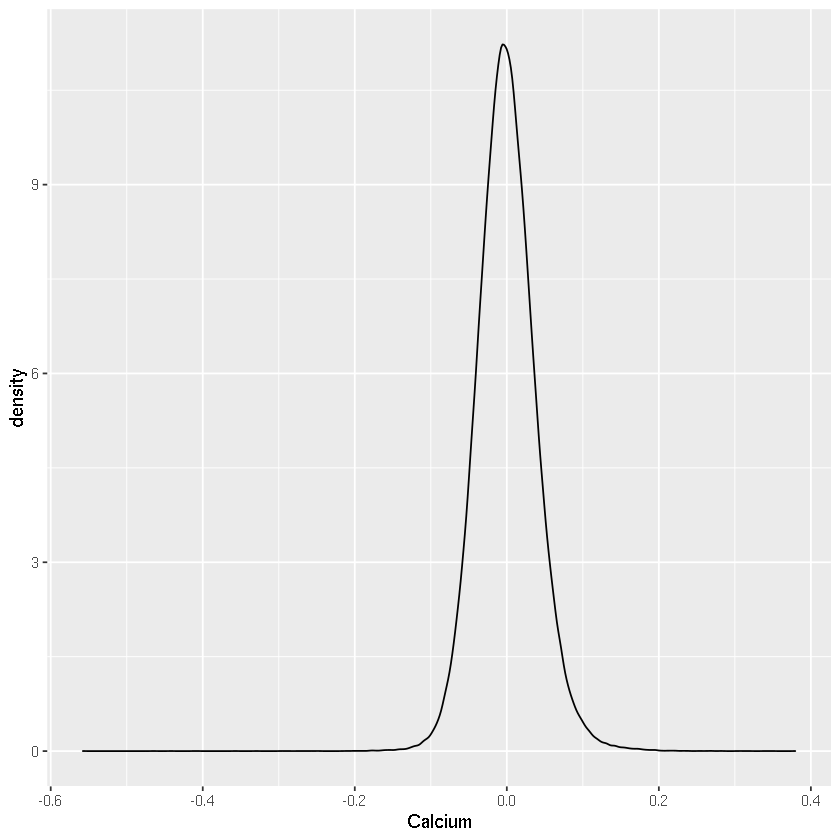

In [24]:
ggplot(df , aes(x=Calcium))+geom_density()

In [25]:
df %>% filter(is.na(Calcium)) %>% nrow()

[1] 20283

In [27]:
df %>% filter(!is.na(Calcium)) %>% nrow()


[1] 199616